# STAT201 Project Final Report  -- Bike Sharing #

-- Group10 : Emma Zhan, Gary Wu, Sparsh Bajaj, Xinya Lu

# Introducton #

The dataset that we have decided to work on for our project is the **Bike Sharing Dataset**. This dataset contains the hourly and daily count of rental bikes between 2011 and 2012 in the Capital bikeshare system with the corresponding weather and seasonal information. The variables that we have decided to focus on for the purpose of our project are weekday, workingday, cnt, casual, and registered variables. 

Our **research question** is; Is there a significant difference in the number of bike rental users during workdays or non-workdays? We will be using the columns cnt (total number of users that day), and workingday (0 meaning not a working day, 1 meaning it is a working day). 

In the study done by ShuiChao Zhang et al (2016), it was found that rental duration between weekdays and weekends are **similar**. However, in the study done by Yang et al (2016), the survey results show that there is a **decrease** in use of bikes during holidays.

Bootstrapping will help us induce sampling variation with one sample to replicate effects of sampling from a population. We decided to use Mean as our sample size is quite large so we can apply the central limit theorem and overall the distribution of the data is symmetrical.

We have decided to use **standard deviation** as our scale parameter as we believe that using distributing the data based on standard deviation will easily allow us to identify any outliers in the data, identify how widely the data is spread around the mean value, and it provides a better variability as compared to range because it gives the measure of variation of the values from the mean of the dataset.

Understanding if there are more users during workdays or non-workdays can help the company effectively allocate resources to days when there are more users. It can help them predict if there are days that more resources are required from consumers.


## Preliminary Results ## 

In [1]:
# loading the library
library(tidyverse)
library(repr)
library(infer)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# figure/table number generator
figure_table_number <- c(0, 0, 0, 0) # figureMajor, figureMinor, tableMajor, tableMinor

generateNumberWithText <- function(type, m, major, minor) {
    if (substring(m, nchar(m)) != ".") {m <- paste(m, ".", sep="")}
    m <- paste(toupper(substring(m, 1, 1)), substring(m, 2, nchar(m)), sep="")
    return(paste(type, major, ".", minor, ". ", m, sep = ""))
}

figure_number.nextMajor <- function(m="") {
    figure_table_number[1] <<- figure_table_number[1] + 1
    figure_table_number[2] <<- 0
    return (generateNumberWithText("Figure: ", m, figure_table_number[1], figure_table_number[2]))
}

figure_number.nextMinor <- function(m="") {
    figure_table_number[2] <<- figure_table_number[2] + 1
    return (generateNumberWithText("Figure: ", m, figure_table_number[1], figure_table_number[2]))
}


table_number.nextMajor <- function(m="") {
    figure_table_number[3] <<- figure_table_number[3] + 1
    figure_table_number[4] <<- 0
    return (generateNumberWithText("Table: ", m, figure_table_number[3], figure_table_number[4]))
}

table_number.nextMinor <- function(m="") {
    figure_table_number[4] <<- figure_table_number[4] + 1
    return (generateNumberWithText("Table: ", m, figure_table_number[3], figure_table_number[4]))
}


In [3]:
# prepartion for the environment

default_plot_width <- 10
default_plot_height <- 10
plotTextSize = 15
set.seed(1)

options(repr.matrix.max.rows = 6)
options(repr.plot.width = default_plot_width, repr.plot.height = default_plot_height)
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

# some constants
SAMPLE_SIZE = 73 # 731 * 0.1
confidence_level = 0.95

In [4]:
# Standardize a plot.

# hjust=T == caption on left
standardize <- function(g, textSize = plotTextSize, hjust=T) { 
    g <- g + labs(x=tools::toTitleCase(g$labels$x), 
            y = tools::toTitleCase(g$labels$y), 
            title = tools::toTitleCase(g$labels$title)) +
    theme(text = element_text(size = textSize), 
          plot.caption = element_text(size = textSize, hjust = hjust))
    return (g)
}

In [5]:
# Clean and wrangle the data

# download zip file
zipFileUrl <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
temp <- tempfile()
download.file(zipFileUrl, temp)
# get the raw data
rawData <- read.csv(unz(temp, "hour.csv"))
unlink(temp)
# above code consult: https://stackoverflow.com/questions/3053833/using-r-to-download-zipped-data-file-extract-and-import-data
head(rawData)

# generate one sample
BikeSharingData <- rawData %>%
    group_by(dteday) %>%
    summarize(cnt = sum(cnt), workingday=mean(workingday)) %>%
    ungroup() %>%
    select(workingday, cnt) %>%
    mutate(isworkingday = (workingday == 1)) %>%
    mutate(isworkingday = as.factor(isworkingday)) %>%
    rep_sample_n(size = SAMPLE_SIZE) %>%
    ungroup() %>%
    select(isworkingday, cnt)

cat(table_number.nextMajor("table for one sample"))
head(BikeSharingData)
cat(table_number.nextMinor("table for one sample with only two columns (is working day and cnt)"))

#sample data for only working days
workingday_BikeSharingData <- filter(BikeSharingData, isworkingday=="TRUE") %>% select(cnt)

#sample data for only non-working days
notworkingday_BikeSharingData <- filter(BikeSharingData, isworkingday=="FALSE") %>% select(cnt)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
3,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
4,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
5,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
6,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1


Table: 1.0. Table for one sample.

isworkingday,cnt
<fct>,<int>
TRUE,5992
TRUE,4362
TRUE,5260
FALSE,7132
TRUE,3894
TRUE,4120


Table: 1.1. Table for one sample with only two columns (is working day and cnt).

This dataset is trustworthy as we did not face any issues while reading this data into R and our preliminary data explorations are very straightforward and easily interpretable. 
After we successfully cleaned and wrangled our data set into tidy format, we designed several plots to determine:
1. The mean distribution of the count of total rental bikes during work days
2. The mean distribution of the count of total rental bikes during non-work days
3. The mean distribution of the count of total rental bikes for the bike sharing data set.

We observed that the mean distribution for all the three cases are fairly similar however, this analysis is quite insufficient which is why we decided to proceed further into the analysis of this data set by testing a null hypothesis and constructing a confidence interval using both bootstrapping and asymptotic methods.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


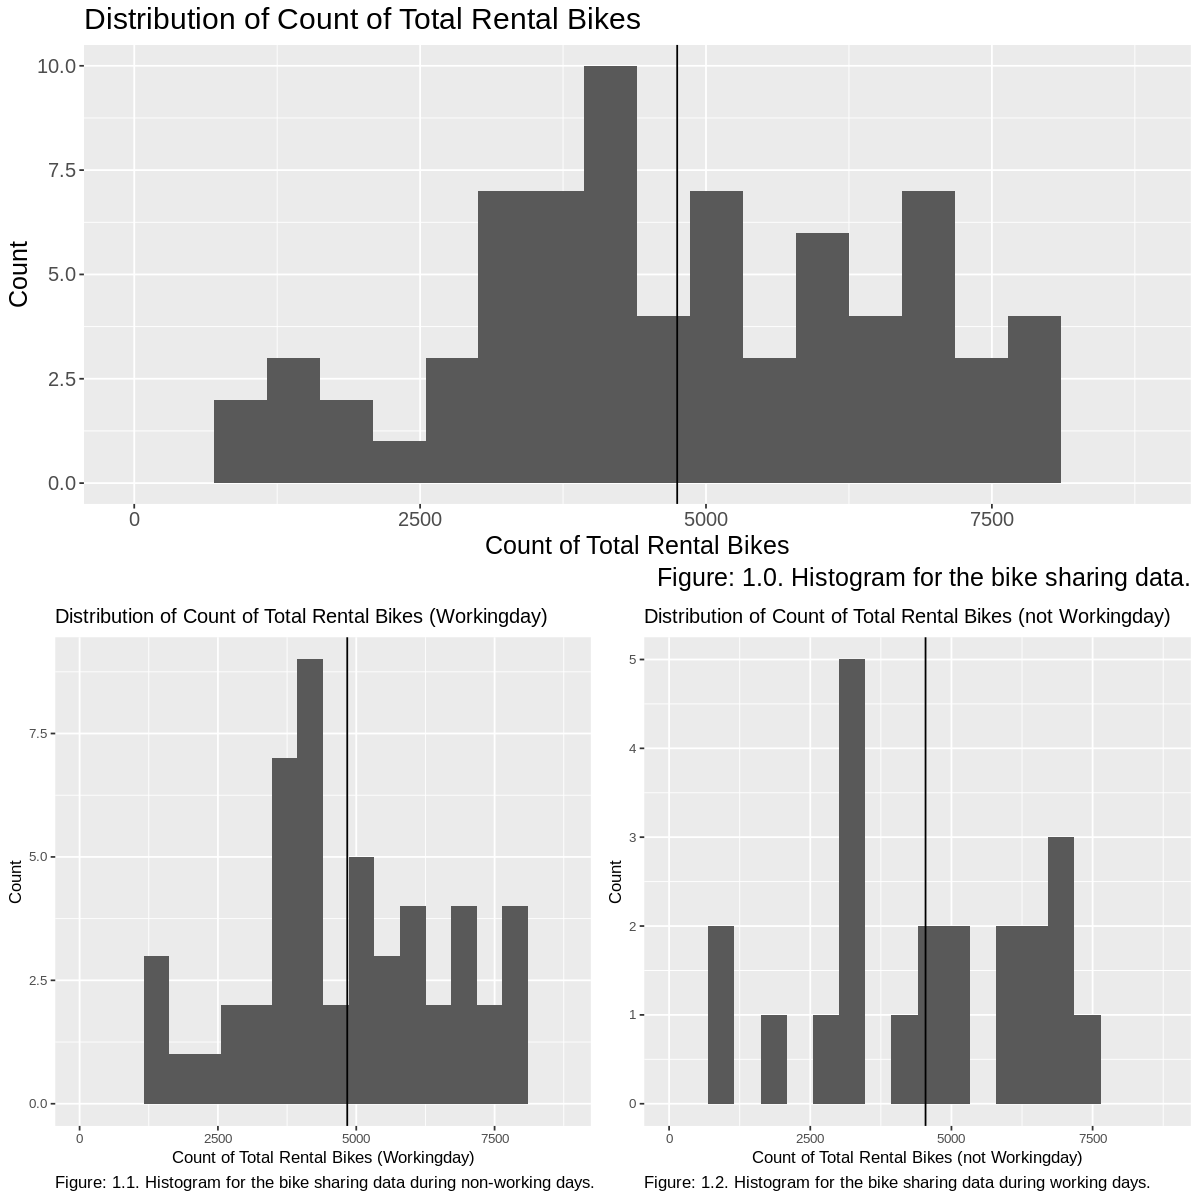

In [6]:
# historgram for all bike sharing data
all_BikeSharingData_hist <- ggplot(BikeSharingData, aes(x = cnt)) +
  geom_histogram(bins=20) +
  labs(x="count of total rental bikes", fill="Is Workingday?") +
  ggtitle("Distribution of count of total rental bikes") +
  geom_vline(xintercept = mean(BikeSharingData$cnt)) +
  theme(legend.position="top") +
  xlim(0, 8800)+
  labs(caption = figure_number.nextMajor("Histogram for the bike sharing data"))
  
# histogram for all biking sharing data during the non-working days
holiday_BikeSharingData_hist <- ggplot(workingday_BikeSharingData, aes(x = cnt)) +
  geom_histogram(bins=20) +
  labs(x="count of total rental bikes (workingday)") +
  ggtitle("Distribution of count of total rental bikes (workingday)") +
  geom_vline(xintercept = mean(workingday_BikeSharingData$cnt)) +
  xlim(0, 8800)+
  labs(caption = figure_number.nextMinor("Histogram for the bike sharing data during non-working days"))

# histogram for all biking sharing data during workdays
notHoliday_BikeSharingData_hist <- ggplot(notworkingday_BikeSharingData, aes(x = cnt)) +
  geom_histogram(bins=20) +
  labs(x="count of total rental bikes (not workingday)") +
  ggtitle("Distribution of count of total rental bikes (not workingday)")+
  geom_vline(xintercept = mean(notworkingday_BikeSharingData$cnt)) +
  xlim(0, 8800)+
  labs(caption = figure_number.nextMinor("Histogram for the bike sharing data during working days"))
grid.arrange(standardize(all_BikeSharingData_hist), 
             grid.arrange(
                 standardize(holiday_BikeSharingData_hist, 10, F), 
                 standardize(notHoliday_BikeSharingData_hist, 10, F), ncol=2), 
            ncol=1)

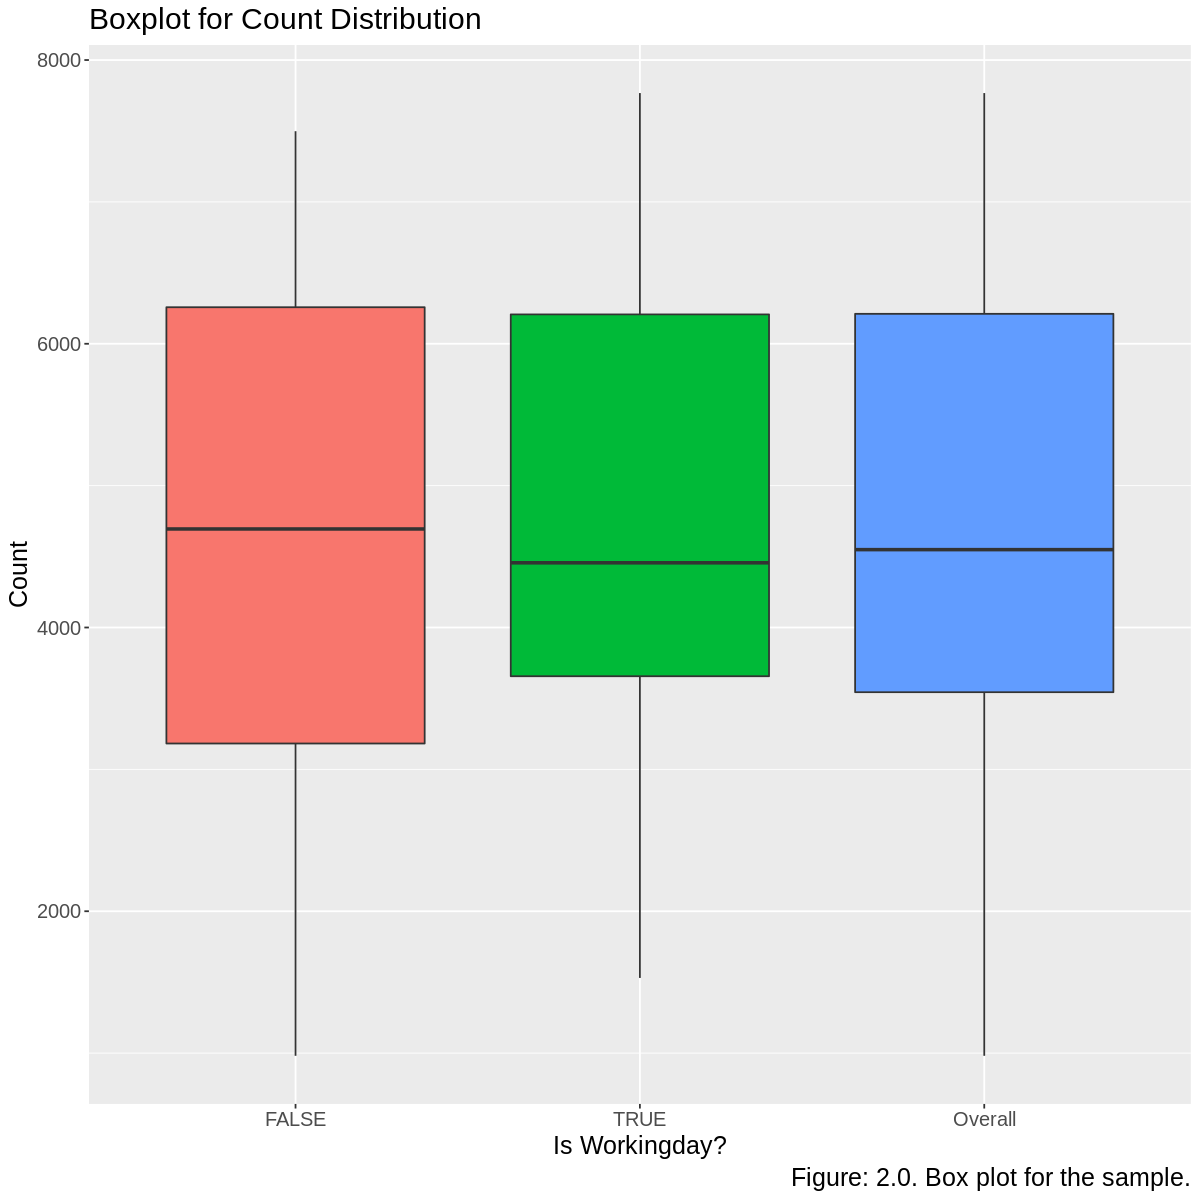

In [7]:
# boxplot using the raw data
boxplot <- ggplot(
    rbind(BikeSharingData, BikeSharingData %>% mutate(isworkingday="Overall")), 
    aes(x=isworkingday, y=cnt, fill=isworkingday)) +
    geom_boxplot() +
    theme(legend.position="none",) +
    labs(x="Is workingday?", y="count", fill = "") +
    ggtitle("Boxplot for count distribution")+
    labs(caption = figure_number.nextMajor("box plot for the sample"))

standardize(boxplot)

Comparing the three boxplots of working day, non-working day, and overall, we see that there is low between group variation as well as low within group variation. This suggests that they do not differ much. 

Looking at table 2.0, the working day mean is about 4837 while the non-working day mean is around 4541. They only differ by 296 users which is a low number compared to large mean. Just by comparing these results, the data suggests that there is not a significant difference between numbers of users in working days vs non-working days. However, the standard deviation for both working day mean and non-working day mean is very large; 1767 and 1997 respectively. The similar mean is subject to sampling variation which makes it unreliable to conclude with. Hence, we must use further statistical inference methods to answer our research question. 

In [8]:
#present the location parameter(mean) and the scale parameter(standard deviation)
parameters <- rbind(BikeSharingData, BikeSharingData %>% mutate(isworkingday="Overall")) %>%
    group_by(isworkingday) %>%
    summarize(mean= mean(cnt), sd= sd(cnt))
parameters
cat(table_number.nextMajor("table for the mean and standard deviation for both working day and non working day"))

isworkingday,mean,sd
<fct>,<dbl>,<dbl>
FALSE,4541.364,1997.093
TRUE,4837.294,1756.747
Overall,4748.110,1823.496


Table: 2.0. Table for the mean and standard deviation for both working day and non working day.

## Methods: Plan ##

Our plan for the project is to conduct a hypothesis test to determine if there is a **significant difference** in the number of registered bike users during non-workdays (wk) and workdays (wr). Thus, for our project, our null hypothesis will be $\mu_{wk} = \mu_{wr}$ and our alternate hypothesis will be  $\mu_{wk} \neq \mu_{wr}$.  The significance level we plan to use in our study is 5% significance level. 

We will find the confidence interval (90%) using four methods; percentile, standard error, CLT with normal distribution, and CLT with t-distribution. We want to compare them to each other and to the bootstrap distribution. The following is the method which we will use to get a 90% confidence interval:
- Step1: Take a Sample from the Dataset
- Step2: Take out 1000 bootstrap samples from the sampling distributions to construct the bootstrap distribution
- Step3: Calculate the upper ci and lower ci using the qnorm() function, qt() function, and get_confidence-interval() functions

We expect to find a significant difference in our results as we expect the number of users to be **higher** during workdays as compared to weekends. We believe that more people will make use of the Bike Sharing services during Workdays to commute to work and as Workdays are in general busier when compared to Weekends. 

Such findings could have significant impact on the business model of the company providing Bike Sharing Services. If it is proven that their services have more demand during the Workdays then they will need to meet up with the increase in demand during Workdays by increasing the supply of available shared bikes during Workdays.

Some future questions that this study could lead to are : 
 1. Do seasons affect the number of Bike Users? 
 2. Does the time of the day have an impact on the Number of Bike Users?

## Bootstrapping ##
For the project, we first decided to create 1000 bootstrap samples and use mean as our location parameter. We decided to create 1000 bootstrap samples from a single sample as we believe that using bootstrap for sampling is a very convenient and cost effective method and it would ensure sampling variation in our resamples while preventing any sampling bias. Next, we visualized our bootstrap distribution of our sampled means in figure 3.0. It can be seen from the figure that the bootstrap distribution is fairly normal and our observed mean is quite close to the mean of our original sample. Our next step was to create a 95% confidence interval on our bootstrap distribution to determine how accurate our estimate is. We decided to set our confidence level at 95% as we think that this will allow us to make an accurate prediction of the possible values of our estimate with adequate certainty.

In [9]:
# calculate sample mean
sample_mean <- mean(BikeSharingData$cnt)

# generate 1000 bootstrap samples using infer workflow and get the sample means
bootstrap_dist <- BikeSharingData %>% 
    specify(response = cnt) %>%
    generate(type = "bootstrap", reps = 1000) %>% 
    calculate(stat = "mean")

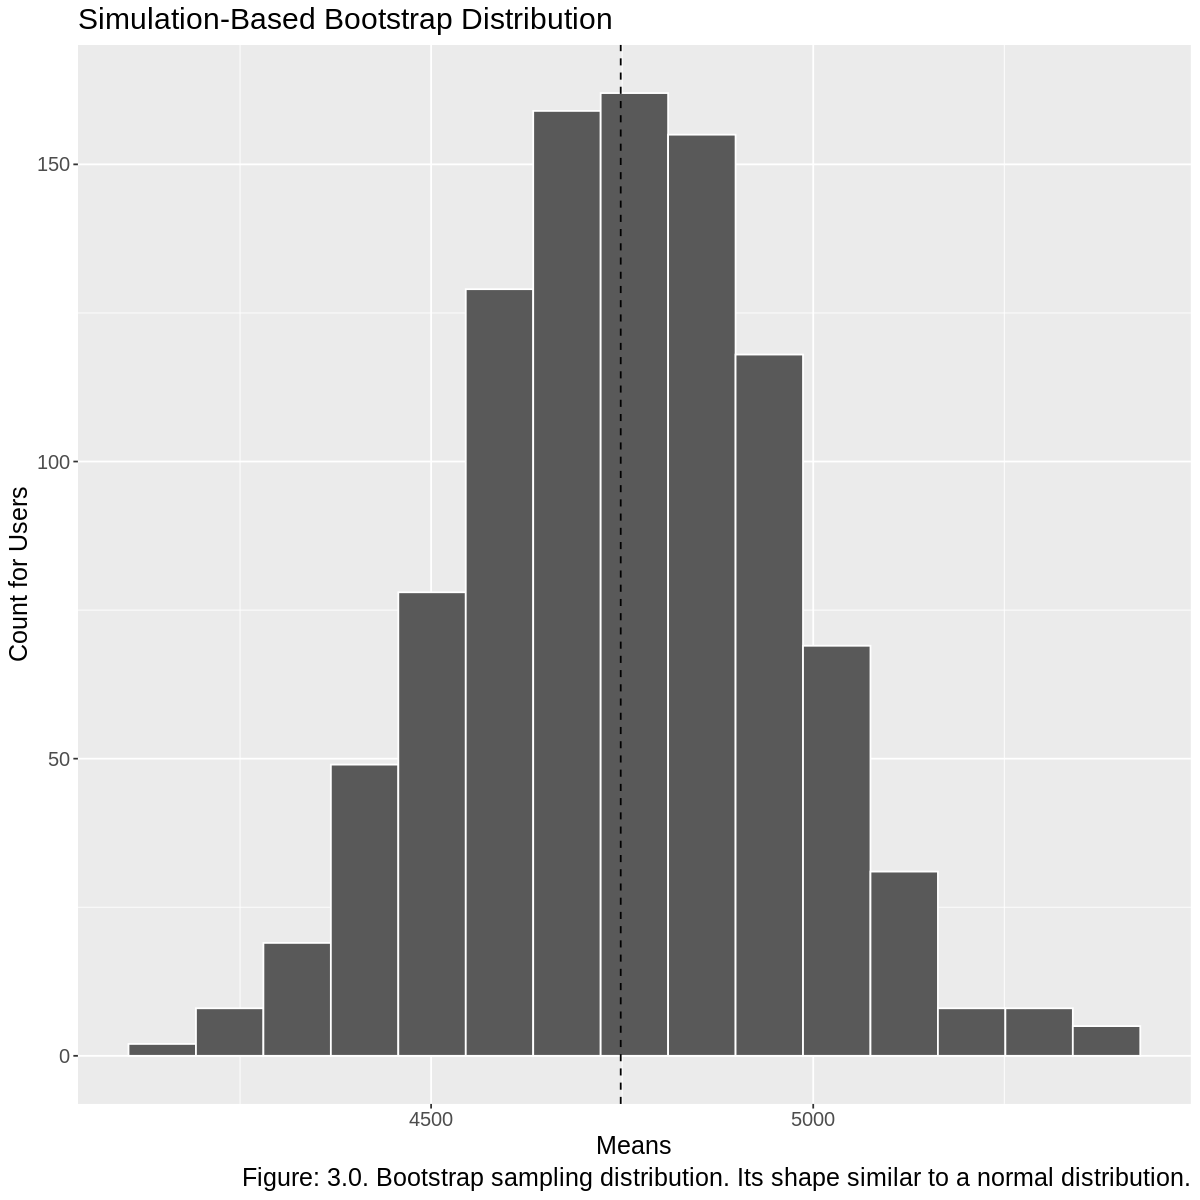

In [10]:
# visualization
g <- visualize(bootstrap_dist) + 
geom_vline(xintercept = sample_mean, linetype = "dashed")  +
labs(caption = figure_number.nextMajor("bootstrap sampling distribution. Its shape similar to a normal distribution.")) +
xlab("means") +
ylab("count for users") +
theme(plot.caption = element_text(size = 20, hjust = 0))
standardize(g)

In [11]:
# get the confidence interval using percentile mothed
ci_percentile <- bootstrap_dist %>% 
    get_confidence_interval(level = confidence_level, type = "percentile")
ci_percentile
cat(table_number.nextMajor("table for bootstrap confidence interval"))

lower_ci,upper_ci
<dbl>,<dbl>
4354.495,5134.448


Table: 3.0. Table for bootstrap confidence interval.

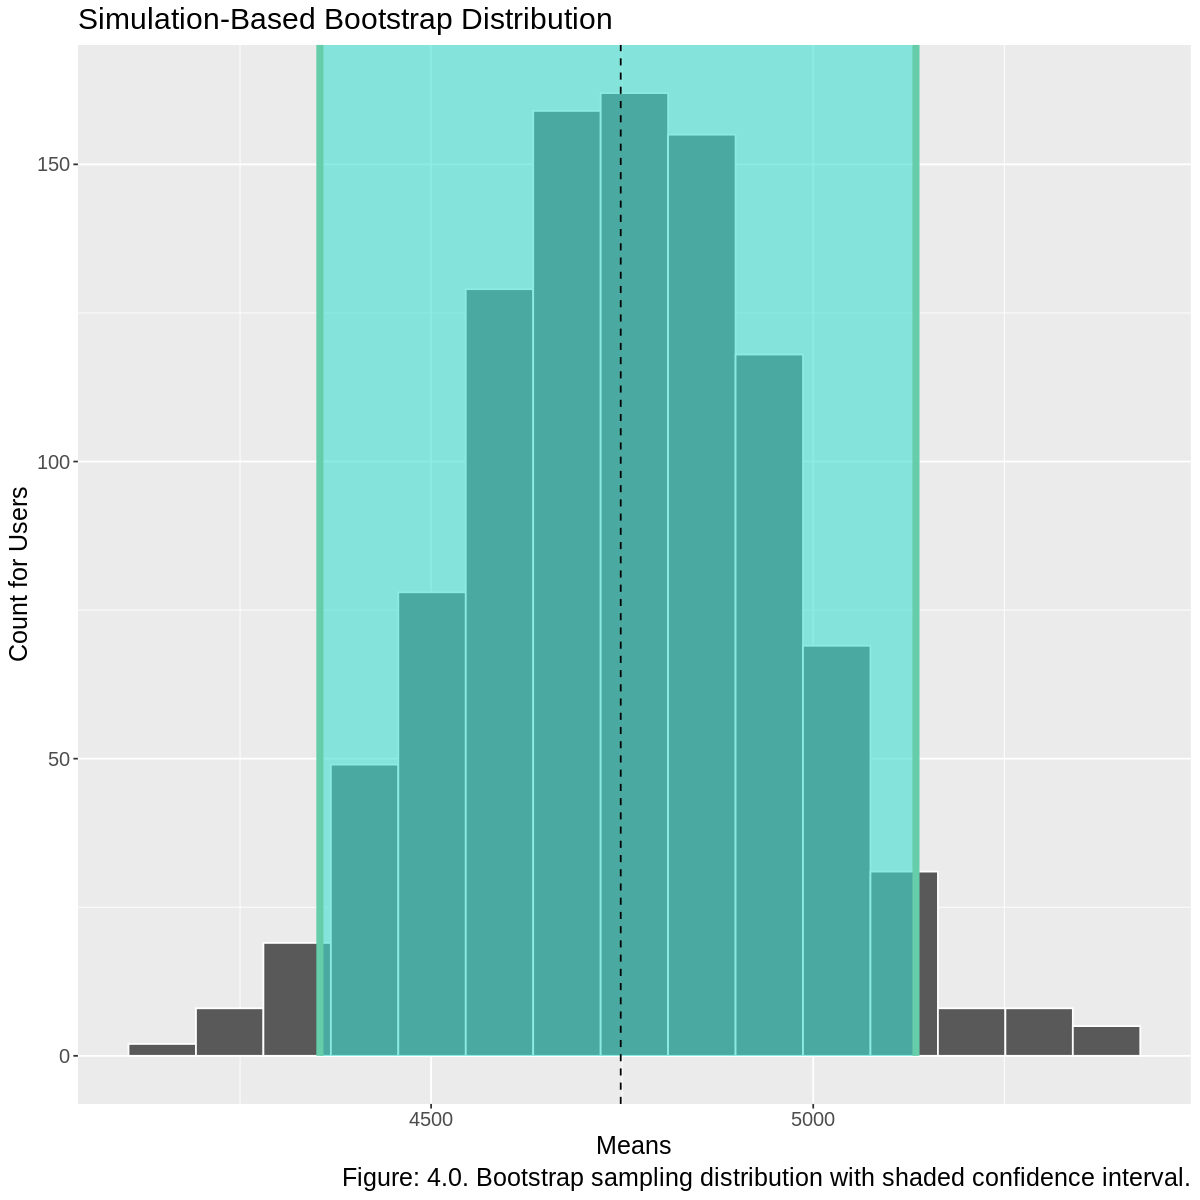

In [12]:
# visualization
ci_plot_percentile <-  visualize(bootstrap_dist) + 
shade_confidence_interval(endpoints = ci_percentile) +
labs(caption = figure_number.nextMajor("bootstrap sampling distribution with shaded confidence interval")) +
geom_vline(xintercept = sample_mean, linetype = "dashed")+
xlab("means")+
ylab("count for users")

standardize(ci_plot_percentile)

In [13]:
# get confidence interval using SE mothed
ci_se <- bootstrap_dist %>% 
    get_confidence_interval(point_estimate = sample_mean, level = confidence_level, type = "se")

# get the confience interval using CLT

# calculate the sample standard deviation
sample_sd <- sd(BikeSharingData$cnt)

# calculate the standard error
se <- (sample_sd / sqrt(nrow(BikeSharingData)))

# lower bound for the confidence interval
lower_ci <- sample_mean + qnorm((1-confidence_level)/2) * se

# upper bound for the confidence interval
upper_ci <- sample_mean + qnorm((1-(1-confidence_level)/2)) * se

clt_ci <- tibble(lower_ci, upper_ci)

# get confidence interval using t distribution
df_t <- nrow(BikeSharingData) - 1

# lower bound for the confidence interval
lower_ci <- sample_mean + qt((1-confidence_level)/2, df_t) * se

# upper bound for the confidence interval
upper_ci <- sample_mean + qt((1-(1-confidence_level)/2), df_t) * se

t_ci <- tibble(lower_ci, upper_ci)

In [14]:
# Summarize CI
summarize_ci <- data.frame(Method=c("Bootstrapping percentile", "Bootstrapping standard errors", "CLT + Normal distribution", "CLT + t distribution"), 
          lower_ci=c(ci_percentile$lower_ci, ci_se$lower_ci, clt_ci$lower_ci, t_ci$lower_ci),
          upper_ci=c(ci_percentile$upper_ci, ci_se$upper_ci, clt_ci$upper_ci, t_ci$upper_ci))
summarize_ci
cat(table_number.nextMajor("Summarize of confidence intervals generated by different methods"))

Method,lower_ci,upper_ci
<chr>,<dbl>,<dbl>
Bootstrapping percentile,4354.495,5134.448
Bootstrapping standard errors,4346.563,5149.656
CLT + Normal distribution,4329.806,5166.413
CLT + t distribution,4322.656,5173.563


Table: 4.0. Summarize of confidence intervals generated by different methods.

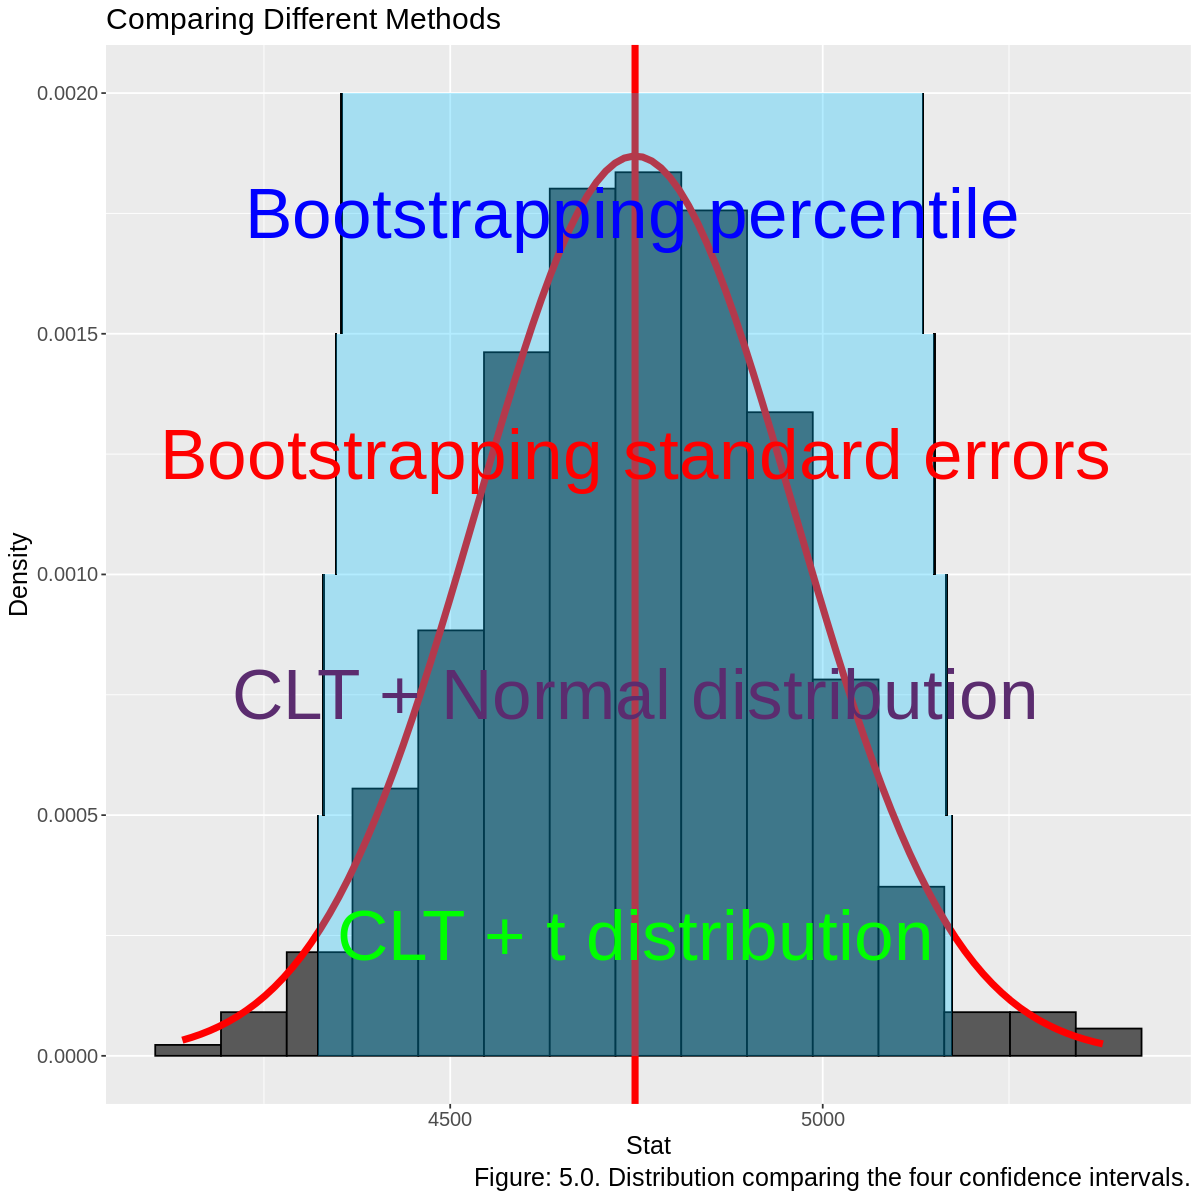

In [15]:
# Compare CI
addAnnotate <- function(graph, low, high, offset, label, blockColor="deepskyblue", labelColor="red") {
    res <- graph +
    geom_segment(aes(x=low, xend=low, y=offset*h, yend =(offset+1)*h)) +
    geom_segment(aes(x=high, xend=high, y=offset*h, yend =(offset+1)*h)) +
    annotate("rect", xmin = low, xmax = high, ymin = offset*h, ymax = (offset+1)*h,
             fill = blockColor,
             alpha = 0.3) +
    annotate("text", x=(low+high)/2, y=h/2+offset*h, label=label, size = 15, color=labelColor)
    return (res)
}

h <- 0.0005
g <- ggplot(bootstrap_dist, aes(x=stat)) + 
geom_histogram(aes(y = ..density..), bins = 15, colour = "black") + 
stat_function(fun = dnorm, args = list(mean = sample_mean, sd = se),
              color = "red", lwd = 2) +
  geom_vline(xintercept = sample_mean, color = "red", lwd = 2) +
labs(title="comparing different methods", caption = figure_number.nextMajor("distribution comparing the four confidence intervals"))

colors <- c("green", "#5b2c6f", "red", "blue")
for (r in nrow(summarize_ci):1) {
    g <- addAnnotate(g, summarize_ci[r, "lower_ci"], summarize_ci[r, "upper_ci"], 4-r, summarize_ci[r, "Method"], labelColor=colors[5-r])
}

standardize(g)

## Interpretation for confidence interval ##
Using the percentile method, the 95% confidence interval lies between 4354 to 5134 total number of users that day. Thus, we are 95% confident that the population mean lies between 4347 and 5150. We expect that 95% of the intervals contain the true population mean. 

Using the standard errors method, the 95% confidence interval lies between 4347 to 5150 total number of users that day. 

Using the CLT normal distribution method, the 95% confidence interval lies between 4330 to 5166  total number of users that day. The reason why we can use CLT in this case is that our sample size is greater than 30. The sample is also randomly selected and less than 10% of population.

Using the t distribution method, the 95% confidence interval lies between 4323 to 5174 total number of users that day. 

In figure 5.0, we are comparing the different methods of obtaining the CI. The red line represents the normal distribution while the bar graph makes up the bootstrap distribution. The blue-shaded region is the CI constructed by each of different methods. We see that CLT + t distribution gives us the widest range while the percentile method is the narrowest. However, we cannot say which one is the best since we do not know the true population parameter. 

It is clear that confidence intervals generated by both CLT and bootstrapping are similar. The reason behind that is the normal approximation is very close to bootstrapping distribution. Furthermore, the t-distribution with the degree of freedom of 72 is very close to normal. Thus, the confidence intervals generated by different methods are similar.

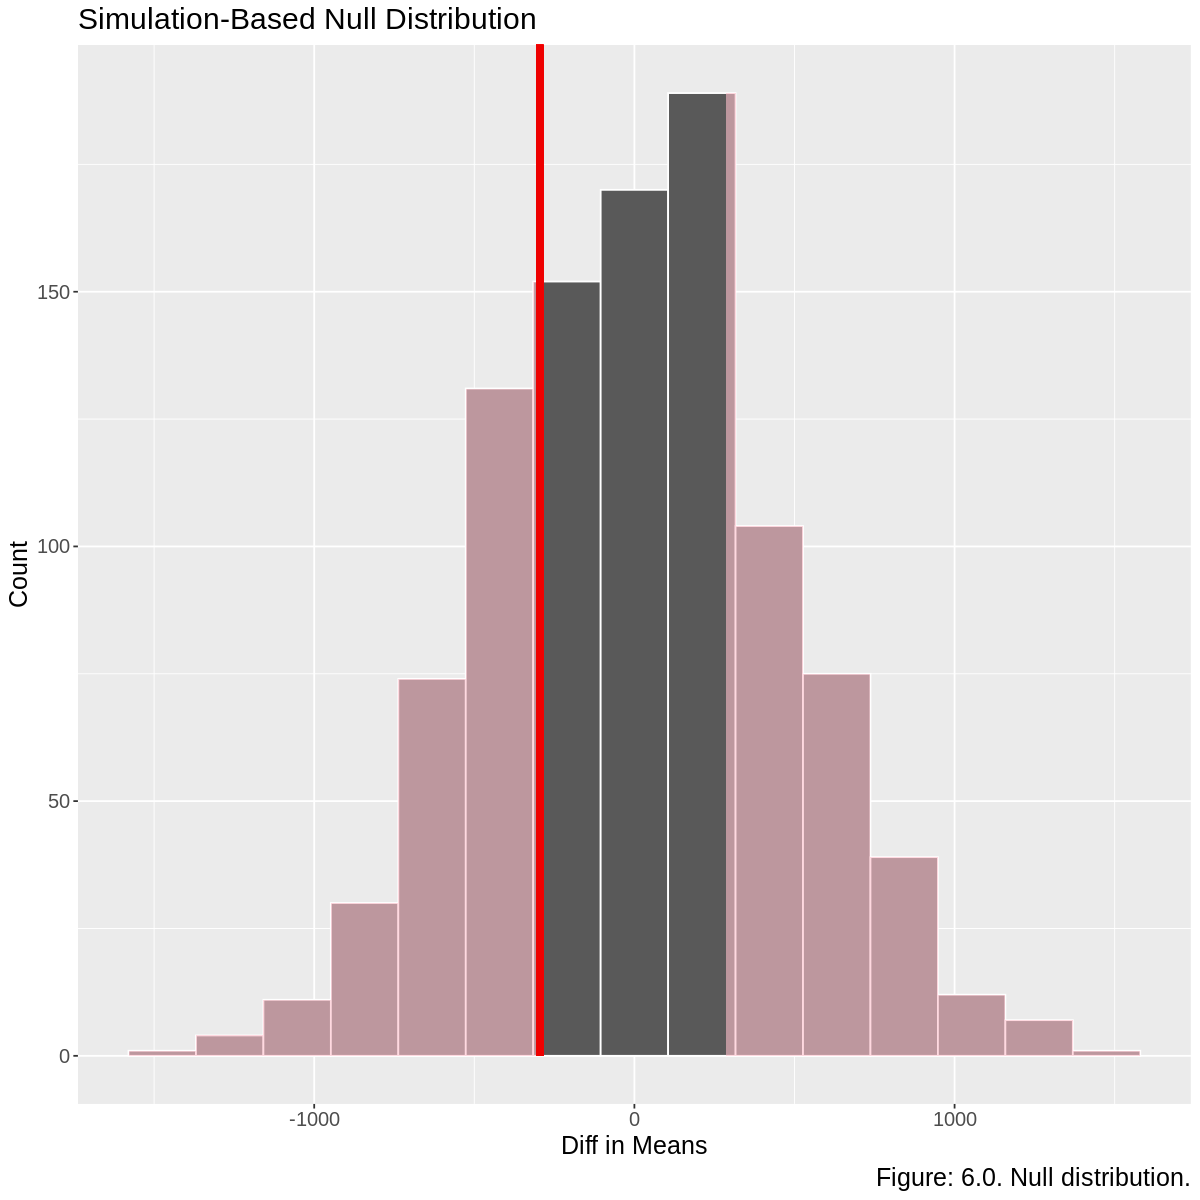

In [16]:
# Hypothesis test
# assume independent, the mean of the count of total rental bikes per day is NOT dependent on workingday or not.
# H_0, mean(is NOT workingday) -  mean(is workingday) = 0
# H_A, mean(is NOT workingday) -  mean(is workingday) != 0
# α = 5%
obs_diff_means <- BikeSharingData %>% 
  specify(formula = cnt ~ isworkingday) %>% 
  calculate(stat = "diff in means", order = c("FALSE", "TRUE"))

null_infer <- BikeSharingData %>% 
  specify(formula = cnt ~ isworkingday) %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "permute") %>% 
  calculate(stat = "diff in means", order = c("FALSE", "TRUE"))

null_plot_infer <- null_infer %>% 
  visualize() + 
  shade_p_value(obs_stat = obs_diff_means, direction = "both") +
  xlab("diff in means") + 
  theme(text = element_text(size=20))+
  labs(caption = figure_number.nextMajor("null distribution"))
  
standardize(null_plot_infer)

In [17]:
# get the p-value 
get_p_value(null_infer, obs_stat = obs_diff_means, direction = "both")
cat(table_number.nextMajor("table for p-value"))

p_value
<dbl>
0.526


Table: 5.0. Table for p-value.

In [18]:
# hypothesis testing using t.test
library(broom)
tidy(t.test(x = workingday_BikeSharingData$cnt, 
            y = notworkingday_BikeSharingData$cnt))
cat(table_number.nextMajor("t test summary."))

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
295.9305,4837.294,4541.364,0.6018094,0.5511053,35.68891,-701.6554,1293.516,Welch Two Sample t-test,two.sided


Table: 6.0. T test summary.

## Interpretation of p-value ##
Using the null distribution, the p-value is 0.526 which is the probability of observing a result that is at least as extreme as the observed value what we assume that the null hypothesis is true. Using the t test, the p-value is 0.551. Both p-values are greater than 0.05, so we conclude that we fail to reject the null hypothesis.

## Discussion ##

Since the p-value is 0.526, we **fail to reject** the null hypothesis at 5% significance level.  Thus, this means our sample did not provide sufficient information to show there is a difference between the registered bike users during the workdays and non-working days. Knowing this, bike companies would not need to allocate more bikes to workdays compared to non-work days. From the results of this project, it suggests that bike rental usage is consistent between working days and non-workdays. 

The results we got are **not** what we expected to find as we were expecting to find a significant difference in the number of registered users during non-work days and working days with a p-value lower than 0.05. We anticipated that users would be much more likely to use the bike sharing services during working days as they would be more likely to commute to work during this time and this would result in more use scenarios for the bikes. 

We can use **other columns** of data in this bike dataset to investigate factors that could contribute to the use of bikes by registered users between working days and non-working days. Even though our results show that there is no significant difference between the number of registered users between non-work days and working days, we could continue to look for other factors that could have a significant effect on usage of bike rentals. We could study the correlation between weather and usage, holiday and usage, and which months have higher usages. 

We think that **bootstrapping** is **more appropriate** as compared to asymptotics as:
   - Bootstrapping is convenient and cost-effective as it resamples a single data set to create multiple stimulated resamples.
   - Bootstrapping allows us to study the effect of sampling variation on our estimates.
   - Bootstrapping is a  straightforward to derive estimates of standard errors and confidence intervals for complex estimators of complex parameters of the distribution,
   - Bootstrapping allows us to estimate the sampling distribution even if we can not access the population.

We think both methods give the **similar** result. Firstly, the p-values are similar and both of them are smaller than 0.05 which lead us not to reject the null hypothesis. Moreover, the confidence intervals gained by the both methods are similar. In Figure 5.0, the confidence interval gained by percentile method and standard error method which are using bootstrapping is similar to the ones gained by the CLT and t-distribution method.

We think both methods are trustworthy but **none** is more trustworthy than the other. Since we can not access the population, we do not know the true population mean, therefore we are not sure which confidence interval is the best.

Some **future questions** that this study could lead to are :
  - Do seasons affect the number of Bike Users?
  - Does the time of the day have an impact on the Number of Bike Users?


## Reference ##

Fanaee-T, Hadi, and Gama, Joao. (2013). Event labeling combining ensemble detectors and background knowledge. *Progress in Artificial Intelligence: pp. 1-15, Springer Berlin Heidelberg*. Retrieved October 31, 2022, from https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset 

Yang, L., Shen, Q., &amp; Li, Z. (2016, July 19). Comparing travel mode and trip chain choices between holidays and weekdays. *Transportation Research Part A: Policy and Practice.* Retrieved October 26, 2022, from https://www.sciencedirect.com/science/article/pii/S0965856416301781 

Zhang, S., He, K., Dong, S., &amp; Zhou, J. (2016, February 15). Modeling the distribution characteristics of urban public bicycle rental duration. *Discrete Dynamics in Nature and Society.* Retrieved October 26, 2022, from https://www.hindawi.com/journals/ddns/2016/8947525/ 